In [1]:
# Global Variables
debug = True                        # Displays additional logging output
savePlots = False                   # Saves plot image files
showCorrelation = False             # Saves information on correlation variablespca = PCA(10)
targetColumnName = "TARGET"         # Name for column denoting dependant variable
outlierThreshold = 3                # Number of standard deviations from which data will be classified as an outlier
dropMissingValues = True #Needs to be true for randomTreeRegressor

# Various file names for debugging and analysis
stringVariablesFile =           './outputFiles/stringVariables.txt'
continuousVariablesFile =       './outputFiles/continuousVariables.txt'
categoricalVariablesFile =      './outputFiles/categoricalVariables.txt'
datasetName =                   './dataset/application_train.csv'
initialDataFileName =           './outputFiles/initialData.txt'
missingValFileName =            './outputFiles/missingValueSummary.txt'
noMissingValuesFileName =       './outputFiles/noMissingValueSummary.txt'
initialDistributionFileName =   './outputFiles/initialDistribution.txt'
dataFrameFileName =             './outputFiles/dataFrameDebug.txt'
generalDebugFileName =          './debug.txt'
testFileName =                  './dataset/application_test.csv'

# Chosen top 10 variables from ASG1
# @TODO: figure out if we want to do a mixture of ext source variables
# @todo: figure out if we want to remove target from these columns
chosenTopTenVariables = ['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'CODE_GENDER', 'EXT_SOURCE_1',
                         'DAYS_BIRTH', 'CNT_CHILDREN', 'AMT_CREDIT', 'NAME_INCOME_TYPE',
                         'NAME_EDUCATION_TYPE']

forestTopTenVariables = ['EXT_SOURCE_3',
                         'TARGET',
'EXT_SOURCE_2',
'EXT_SOURCE_1',
'AMT_ANNUITY',
'DAYS_EMPLOYED',
'AMT_CREDIT',
'DAYS_ID_PUBLISH',
'DAYS_REGISTRATION',
'LIVINGAREA_MODE',
'AMT_GOODS_PRICE',
]

flagColumns = ['FLAG_MOBIL',
               'FLAG_EMP_PHONE',
               'FLAG_WORK_PHONE',
               'FLAG_CONT_MOBILE',
               'FLAG_PHONE',
               'FLAG_EMAIL',
               'FLAG_DOCUMENT_2',
               'FLAG_DOCUMENT_3',
               'FLAG_DOCUMENT_4',
               'FLAG_DOCUMENT_5',
               'FLAG_DOCUMENT_6',
               'FLAG_DOCUMENT_7',
               'FLAG_DOCUMENT_8',
               'FLAG_DOCUMENT_9',
               'FLAG_DOCUMENT_10',
               'FLAG_DOCUMENT_11',
               'FLAG_DOCUMENT_12',
               'FLAG_DOCUMENT_13',
               'FLAG_DOCUMENT_14',
               'FLAG_DOCUMENT_15',
               'FLAG_DOCUMENT_16',
               'FLAG_DOCUMENT_17',
               'FLAG_DOCUMENT_18',
               'FLAG_DOCUMENT_19',
               'FLAG_DOCUMENT_20',
               'FLAG_DOCUMENT_21',
               'LIVE_CITY_NOT_WORK_CITY']
#, 'ORGANIZATION_TYPE'*/]

lineString = "---------------------------------------------------------------------------------------------------------"

debugFd = open(generalDebugFileName, "w+")

if debug == True:
    debugFd.write("Global Variables Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [2]:
# Library Imports
from nis import cat
from re import X
import pandas as pd                 # Used for data frame
import plotly                       # Saves html plots
import plotly.express as px         # Used for displaying plots
import os                           # Allows file manipulation and console debugging for offline jupyter
import numpy as np
from scipy import stats             # Used for outliers
import matplotlib.pyplot as plt     # Used for pyplot heatmap plotting
import seaborn as sns               # Used for showing heatmap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler # Used for standardizing data for PCA and K-means clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
    # Import the model we are using
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import operator

from sklearn.ensemble import RandomForestRegressor
#@TODO: Figure out if we want to delete this or not and use the sklearn tree
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz # Data Tree Visualization

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import pickle                                   # Saving Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import graphviz # Data Tree Visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import pydot

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

if debug == True:
    print("Library Imports Cell Completed...")
    print(lineString)

Library Imports Cell Completed...
---------------------------------------------------------------------------------------------------------


In [3]:
# Module Imports

if debug == True:
    debugFd.write("Module Imports Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [4]:
# Software configurations
pd.options.display.max_rows = 4000  # Allows better debugging analysis

if debug == True:
    debugFd.write("Software Configuration Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [5]:
# Helper Functions

# If the debugging flag is on, creates directories to store output data
#
# Parameters:
# -----------
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def createOutputDirectories(debug = False):
    if debug == False:
        return
    if not os.path.exists("images"):
        os.mkdir("images")
    if not os.path.exists("images/hierarchicalClustering"):
        os.mkdir("images/hierarchicalClustering")
    if not os.path.exists("images/pca"):
        os.mkdir("images/pca")
    if not os.path.exists("images/initialPlots"):
        os.mkdir("images/initialPlots")
    if not os.path.exists("images/topTenPlots"):
        os.mkdir("images/topTenPlots")
    if not os.path.exists("outputFiles"):
        os.mkdir("outputFiles")
    print("createOutputDirectories...success")


# Reads csv file into data frame and sets independant and dependant variables
#
# Parameters:
# -----------
# @param fileName: string for full relative file path of csv file
# @param dependantVarColumnName: csv file column matching name of column for dependant variable
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object of csv file reading
# independantVars: independant variables (all data that isn't targetColumnName)
# dependantVar: dependant variable
#
def readData(fileName, dependantVarColumnName = targetColumnName, debug = False):
    independantVars = []
    dependantVar = []
    data = pd.read_csv(fileName)
    index = None
    for i ,col in enumerate(data.columns):
        if col == dependantVarColumnName:
            index = i
    if index != None: 
        dependantVar = data.iloc[:, index]
        independantVars = data.iloc[:]
        independantVars.pop(dependantVarColumnName)
    if debug:
        fd = open(initialDataFileName, "w+")
        fd.write("This file contains the initial data frame without cleaning:\n")
        fd.write(str(data))
        fd.close()
        print("readData...completed")
    return data, independantVars, dependantVar


# Drops rows from dataset which are missing. Prints missing value data for debugging
#
# Parameters:
# -----------
# @param data: dataframe to have missing values dropped and returned
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object with missing values dropped
#
def dropMissingValues(data, debug = False):
    # Drop missing values
    ret = data.dropna(axis=0)
    # Show number of missing values per independant variable
    if debug:
        fd = open(missingValFileName, "w+")
        fd.write("This data shows the independant variables which contained missing values and the count of each:\n")
        fd.write(str(data.isnull().sum()))
        fd.close()
        fd = open(noMissingValuesFileName, "w+")
        fd.write("This data shows the independant variables which are used for analysis with no mising values:\n")
        fd.write(str(ret.isnull().sum()))
        fd.close()
        print("dropMissingValues...completed")
    return ret


def setMeanValues(data, debug = False):
    return data

# Writes distribution of data frame to text file
#
# Parameters:
# -----------
# @param data: dataframe to have distribution written to text file
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def writeDistribution(data, debug = False):
    if debug == False:
        return
    numpy_array = data.to_numpy()
    fd = open(initialDistributionFileName, "w+")
    fd.write(str(numpy_array))
    fd.close()
    print("writeDistribution...success")


def doBar(data, column_name, figsize = (18,6), 
          percentage_display = True,
          plot_defaulter = True, rotation = 0, 
          horizontal_adjust = 0, 
          fontsize_percent = 'xx-small',
          dirName = 'images/initialPlots/'):

    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)


# Plots a column name of the dataframe and saves each plot into a file
#
# Parameters:
# -----------
# @param data:       dataframe to have distribution written to text file
# @param plots:      types of plots for each column to show e.g. "box"
# @param: figsize:   size of figure for matplotlib to plot
# @param: log_scale: flag to log the scale of the plot
#
# Returns:
# ---------
# None
#
def plot_column(data,
                column_name,
                plots = [],
                figsize = (20,8),
                log_scale = False,
                dirName = 'images/initialPlots/'):

    if 'bar' in plots:
        doBar(data, column_name, figsize, dirName = dirName)
        return
    data_to_plot = data.copy()
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, len(plots), i + 1)
        plt.subplots_adjust(wspace=0.25)
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        elif ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')
        elif ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
        elif ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)


def showTargetPlot(data, debug = False):
    class_dist = data[targetColumnName].value_counts()

    if debug == True:
        print(class_dist)

    plt.figure(figsize=(12,3))
    plt.title('Distribution of TARGET variable')
    plt.barh(class_dist.index, class_dist.values)
    plt.yticks([0, 1])

    for i, value in enumerate(class_dist.values):
        plt.text(value-2000, i, str(value), fontsize=12, color='white',
                 horizontalalignment='right', verticalalignment='center')
    plt.show()


def showHeatmap(data):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),cmap="RdYlGn")
    plt.show()


# Allocates data frames for each data type of argument data frame
# @TODO: implement data frame of integer types not being labeled as categorical
#
# Parameters:
# -----------
# @param data:   dataframe to be split into respective types
# @param debug: flag for displaying debugger output of writing columns into respective files
#
# Returns
# ---------
# strTypes           columns of string type
# continuousTypes    columns of continuous variables
# categorical        columns of categorical types
#
def allocateTypes(data, debug = False):
    strTypes = data.select_dtypes(include='object')
    continuousTypes = data.select_dtypes(include = ['float64', 'int64'])
    if debug == True:
        fd = open(stringVariablesFile, "w+")
        fd.write("String-type variables:\n")
        fd.write(lineString)
        for col in strTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        fd = open(continuousVariablesFile, "w+")
        fd.write("Continuous-type variables:\n")
        fd.write(lineString)
        for col in continuousTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        print("allocateTypes...success")
    return strTypes, continuousTypes


# Workaround to insert string into file without overwriting contents
#
# Parameters:
# -----------
# @param originalfile: original file name
# @param string:       string to be written to file
#
# Returns:
# ---------
# None
#
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('newfile.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('newfile.txt',originalfile)


# @TODO: figure out a try except for the format of the numpy array printed out
# Prints a data frame
#
# Parameters:
# -----------
# @param data: dataframe to be printed
#
# Returns:
# ---------
# None
#
def printDataFrame(data):
    numpy_array = data.to_numpy()
    numpy_array = [i for i in numpy_array if str(i) != 'nan']
    
    try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%d")
    except:
        try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%s")
        except:
            try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%f")
            except: print("error in types")
    
    columnNames = ""
    for i in data.columns:
        columnNames = columnNames + i + " "
    columnNames = columnNames + "\n"
    insert(dataFrameFileName, columnNames)


if debug == True:
    debugFd.write("Helper Functions Cell Completed...\n")
    debugFd.write(lineString+"\n")

In [6]:
# Main Method:
#-------------
# Reads in the data files, plots certain values and creates useful analytical plots and does
# some light data cleaning
#
#
# Parameters:
# -----------
# @param debug:             flag for displaying debugger output
# @param dropMissingValues: true to drop rows with empty values, false to set null values to mean
# @param: savePlots:        true to plot various initial data points
# @param outlierThreshold:  z-value with which to threshold outliers
#
# Returns:
# ---------
# None
#
def main(debug = True, dropMissingValues = False, savePlots = False, outlierThreshold = 3):

    # Create output directories for files and plots to be saved to
    createOutputDirectories(debug)

    # Read the data, assigning independant and dependant variables: x and y respectively
    data, x, y = readData(datasetName, targetColumnName, debug)
    
    data = data.dropna(axis=0)
    #df = df.dropna()

    
    # Shows distribution of independant variable, and shows heatmap, if desired
    if savePlots == True:
        showHeatmap(data)
        showTargetPlot(data, debug)

    # Drop missing values or fill in empty values with mean
    if dropMissingValues == True: 
        data = dropMissingValues(data, debug)
    else:
        data = setMeanValues(data, debug)

    # Show data distribution and allow for manual analysis of outliers
    writeDistribution(data, debug)
    
    # Remove outliers past threshold of 3
    #data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

    # Get sub-data frames that contain variables from each respective data type
    data_strings, data_continuous, data_categorical = allocateTypes(data, debug)

    # Feature engineering for a credit to income ratio
    #data_continuous.insert(0, 'loan_ratio', data_continuous['AMT_CREDIT'] /data_continuous['AMT_INCOME_TOTAL'] / 100)
    #plot_column(data_continuous, 'loan_ratio', ['box'])

    # Show plots from data for outlier analysis
    # [] denotes all variables to look at
    if savePlots == True: 
        showPlots(data, [], debug)
        for i in data_strings.columns:
            plot_column(data_strings, i, ['bar'])
        for i in data_continuous.columns:
            plot_column(data_continuous, i, ['box'])
        for i in data_categorical.columns:
            plot_column(data_categorical, i, ['bar'])
            
    # show plots for chosen variables
    topTenDf = data[chosenTopTenVariables]
    # 10 plus TARGET
    assert(len(topTenDf.columns) == 11)
    #printDataFrame(topTenDf)
    topTenStrings, topTenContinuous, topTenCategorical = allocateTypes(topTenDf, debug)
    if savePlots == True:
        for i in topTenStrings.columns:
            plot_column(topTenStrings, i, ['bar'], dirName = 'images/topTenPlots/')
        for i in topTenContinuous.columns:
            plot_column(topTenContinuous, i, ['box'], dirName = 'images/topTenPlots/')
        for i in topTenCategorical.columns:
            plot_column(topTenCategorical, i, ['bar'], dirName = 'images/topTenPlots/')
        
    # One hot encoding for categorical variables
    topTenStrings = pd.get_dummies(topTenStrings)
    
    # Target column for labels in value prediction
    labels = np.array(data[targetColumnName])
    
    # Remove target column from features
    topTenStrings = topTenStrings.drop(targetColumnName, axis = 1)
    topTenContinuous = topTenContinuous.drop(targetColumnName, axis = 1)
    topTenCategorical = topTenCategorical.drop(targetColumnName, axis = 1)
    
    # Save columnNames
    stringsColumns = list(topTenStrings.columns)
    continouousColumns = list(topTenContinuous.columns)
    categoricalColumns = list(topTenCategorical.columns)
    
    # Concatenate data frames
    features = pd.concat([topTenStrings, topTenContinuous, topTenCategorical], axis=1)
    
    #features = dropMissingValues(features, debug = debug)
    features.dropna(axis=0, how='all', inplace=True)

    #printDataFrame(topTenStrings)
    #printDataFrame(topTenContinuous)
    
    feature_list = list(features.columns)
    print(feature_list)
    
    #Convert to numpy array
    strings = np.array(topTenStrings)
    continuous = np.array(topTenContinuous)
    categorical = np.array(topTenCategorical)

    features = np.array(features)
    
    #@TODO: may not actually have to do anything to split into test and training sets...
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    
    #    >>> iris = load_iris()
    #>>> X, y = iris.data, iris.target
    #>>> clf = tree.DecisionTreeClassifier()
    #>>> clf = clf.fit(X, y)
    iris = load_iris()
    train_features, train_labels = iris.data, iris.target

    #X = [[0, 0], [1, 1]]
    #Y = [0, 1]
    clf = tree.DecisionTreeClassifier()
    #clf = clf.fit(topTenStrings, labels)
    clf = clf.fit(train_features, train_labels)
    print("Finished clf")
    #tree.plot_tree(clf)
    
    plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
    tree.plot_tree(clf, fontsize=10)
    plt.show()
    
    # The score method returns the accuracy of the model
    #score = clf.score(test_features, test_labels)
    #print("Printing clf score: ")
    #print(score)
    
    # Predict for 1 observation
    #clf.predict(X_test.iloc[0].values.reshape(1, -1))
    # Predict for multiple observations
    
    #print("Classification Tree Predictions: ")
    #print(clf.predict(test_features))
    
    #dot_data = tree.export_graphviz(clf, out_file=None) 
    #dot_data = tree.export_graphviz(clf, out_file=None, 
    #                  feature_names=feature_list,  
    #                  class_names=iris.target_names,  
    #                  filled=True, rounded=True,  
    #                  special_characters=True)  
    #graph = graphviz.Source(dot_data) 
    #graph.render("iris") 
    #graph 
    
    print("Finished graphing clf classifier")
    
    clf = tree.DecisionTreeRegressor()
    #clf = clf.fit(train_features, train_labels)
    #plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
    #tree.plot_tree(clf, fontsize=10)
    #plt.show()
    
    print("Finished graphing clf regressor")
    
    # Instantiate model with 1000 decision trees
    #rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    #rf.fit(train_features, train_labels);

    # Set up random tree forest
    # @TODO: make sure you figure out grouping first. 

    
    
    
    #split dataset in features and target variable
    X = data[chosenTopTenVariables] # Features
    y = data['TARGET'] # Target variable
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
    
    # Create Decision Tree classifer object
    clf = tree.DecisionTreeClassifier()

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    
    if debug == True:
        debugFd.write("Main Method Cell Completed...\n")
        debugFd.write(lineString+"\n")

In [7]:
    
    #if debug == True:
    #    print("Before dropping outliers")
    #    print(data.describe())
    #   print()
    """
    means = {}
    stds= {}
    for col in data.columns:
        if not isinstance(data[col][0], str):
            means[col] = data[col].mean()
            stds[col] = data[col].std()
    print(means)
    print(stds)
    print()
    
    print("Data shape before removing outliers: ")
    print(data.shape)
    for i, row in enumerate(data.iterrows()):
        for key, item in means.items():
            print(key)
            print(data[key][i])
            #if np.abs(row[key] - means[key]) <= outlierThreshold*stds[key]:
            #    data.drop[data.index[i]]
    print("Data shape after removing outliers: ")
    print(data.shape)
    """    

    #data[np.abs(data-data.mean()) <= (outlierThreshold*data.std())]
    #if debug == True: 
    #    print("After dropping outliers")
    #    print(data.describe())
    #    print()

'\nmeans = {}\nstds= {}\nfor col in data.columns:\n    if not isinstance(data[col][0], str):\n        means[col] = data[col].mean()\n        stds[col] = data[col].std()\nprint(means)\nprint(stds)\nprint()\n\nprint("Data shape before removing outliers: ")\nprint(data.shape)\nfor i, row in enumerate(data.iterrows()):\n    for key, item in means.items():\n        print(key)\n        print(data[key][i])\n        #if np.abs(row[key] - means[key]) <= outlierThreshold*stds[key]:\n        #    data.drop[data.index[i]]\nprint("Data shape after removing outliers: ")\nprint(data.shape)\n'

In [8]:
# Main Method:
#-------------
# Reads in the data files, plots certain values and creates useful analytical plots and does
# some light data cleaning
#
#
# Parameters:
# -----------
# @param debug:             flag for displaying debugger output
# @param dropMissingValues: true to drop rows with empty values, false to set null values to mean
# @param: savePlots:        true to plot various initial data points
# @param outlierThreshold:  z-value with which to threshold outliers
#
# Returns:
# ---------
# None
#
def pain(debug = True, dropMissingValues = False, savePlots = False, outlierThreshold = 3):

    # Create output directories for files and plots to be saved to
    createOutputDirectories(debug)

    # Read the data, assigning independant and dependant variables: x and y respectively
    data, x, y = readData(datasetName, targetColumnName, debug)
    testData = pd.read_csv(testFileName)
    # Assign data to only our top ten variables to save runtime and data cleaning
    #data = data[chosenTopTenVariables]
    #data = data[forestTopTenVariables]
    #assert(len(data.columns) == 10)
    
    # Drop bad values from the variables we care about
    #data = data.dropna(axis=0)
    #for col in data.columns:
    #    assert(data[col].isnull().sum() == 0)
    #if debug == True:
    #    print("Null data values properly dropped")

    # Allocate feature and label data frames
    labels = pd.DataFrame()
    labels[targetColumnName] = data[targetColumnName]
    features = data.drop(targetColumnName, axis = 1)

    # Normalize days birth to something reasonable
    if 'DAYS_BIRTH' in features.columns:
        yearsBorn = round(abs(features['DAYS_BIRTH'] / (365)))
        features['DAYS_BIRTH'] = round(abs(features['DAYS_BIRTH'] / (365)))

    # Remove outliers past threshold of 3
    #data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

    # Get sub-data frames that contain variables from each respective data type - we don't want target
    dataStrings, dataContinuous = allocateTypes(features, debug)
    
    # One hot encoding for categorical variables
    # We want to avoid multi-colinearity here, so drop the first categorical variable
    if len(dataStrings.columns) > 0:
        dataStrings = pd.get_dummies(dataStrings)
    
    # Re-merge data types now
    features = dataContinuous.join(dataStrings)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.7, random_state=1)
    

    # Visualize original dimensions if desired
    if False:
        fig = px.scatter_matrix(data,
                                dimensions = features,
                                width = 2000,
                                height = 2000,
                                color = targetColumnName)
        fig.update_traces(diagonal_visible=False)
        fig.write_image("images/initial_dimensions.png")
        if debug == True:
            print("Initial Dimensions Plotting...success")

    # Create and visualize PCA with top ten components
    print("Features shape: ", features.shape)
    pca = PCA(n_components = 10) # Bringing 234 features down to 10
    components = pca.fit_transform(features)
    print("Components shape: ", components.shape)
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    if savePlots == True:
        fig = px.scatter_matrix(components,
                                labels=labels,
                                dimensions=range(4),
                                color=data[targetColumnName])
        fig.update_traces(diagonal_visible=False)
        fig.write_image("images/pca.png")
        if debug == True:
            print("PCA Plotting...success")
    
    if debug == True:
        debugFd.write("Main Method Cell Completed...\n")
        debugFd.write(lineString+"\n")

In [9]:
# Create output directories for files and plots to be saved to
createOutputDirectories(debug)

# Read the data, assigning independant and dependant variables: x and y respectively
data, x, y = readData(datasetName, targetColumnName, debug)
print("Initial Data shape: ", data.shape)
testData = pd.read_csv(testFileName)
data = data.append(testData).reset_index()
print("All Data shape: ", data.shape)


# Remove columns missing >= 70% of their values    
df2 = data[[column for column in data if data[column].count() / len(data) >= 0.3]]
del df2['SK_ID_CURR']
if debug == True: 
    print("List of dropped columns:", end=" ")
    for c in data.columns:
        if c not in df2.columns:
            print(c, end=", ")
    print('\n')
data = df2

# Select numerical and presumably continuous data types 
df_num = data.select_dtypes(include = ['float64', 'int64'])
# Remove the boolean flag type columns
df_num = df_num[[column for column in df_num if column not in flagColumns]]
if debug == True:
    print("Numerical data types extracted")

# avoid having the matplotlib verbose informations
if savePlots == True:
    df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

df_num_corr = df_num.corr()[targetColumnName][:] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > .04].sort_values(ascending=False)
print("There is {} strongly correlated values with TARGET:\n{}".format(len(golden_features_list), golden_features_list))
print(lineString)

# Show pairplots for continuous variables
if savePlots == True:
    for i in range(0, len(df_num.columns), 5):
        sns.pairplot(data=df_num,
                    x_vars=df_num.columns[i:i+5],
                    y_vars=[targetColumnName])

createOutputDirectories...success
readData...completed
Initial Data shape:  (307511, 122)


/tmp/ipykernel_76187/1961772227.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(testData).reset_index()


All Data shape:  (356255, 123)
List of dropped columns: SK_ID_CURR, 

Numerical data types extracted
There is 16 strongly correlated values with TARGET:
TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
REG_CITY_NOT_LIVE_CITY         0.044395
DAYS_REGISTRATION              0.041975
FLOORSMAX_MODE                -0.043226
FLOORSMAX_MEDI                -0.043768
FLOORSMAX_AVG                 -0.044003
DAYS_EMPLOYED                 -0.044932
EXT_SOURCE_1                  -0.155317
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_3                  -0.178919
Name: TARGET, dtype: float64
---------------------------------------------------------------------------------------------------------


In [10]:
if showCorrelation == True:
    individual_features_df = []
    for i in range(0, len(df_num.columns)):
        tmpDf = df_num[[df_num.columns[i], targetColumnName]]
        tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
        individual_features_df.append(tmpDf)

    all_correlations = {feature.columns[0]: feature.corr()[targetColumnName][0] for feature in individual_features_df[1:]}
    all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
    for (key, value) in all_correlations:
        print("{:>15}: {:>15}".format(key, value))
    if debug == True:
        print(lineString)
        golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.04]
        print("There is {} strongly correlated values with TARGET:\n{}".format(len(golden_features_list), golden_features_list))
        print(lineString)


## PCA Creation and Plotting
This snippet will show the shape of the data, create a PCA with the top 10 components, and plot a scatter matrix of each of the 10 Principal Components and save it to /images/pca.png

### Top 10 Principal Components
Generally we want >95% variance captured by the PCA fit. 

### Visualization
The scatter matrix of each of the principal components is saved to:
    /images/<"deleted_rows" or "mean_values_filled">/pca.png

### References
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/
https://www.datacamp.com/tutorial/principal-component-analysis-in-python

### Initial Prompt
Create a PCA in Python and determine the top 10 principal components. Visualize the PCA. What does this tell you about the density of the data?

In [11]:
# Very small value to ensure standardization success
deltaMean = .001

# Number of Principal Components we want to create
numComponents = 40
# Flag for either dropping rows with null values or filling in mean values
deleteRows = True
deleteDescription = ""

# Clean data and print useful output
if deleteRows:
    deleteDescription = "deleted_rows"
    if debug == True:
        print("Deleting missing entries: previous shape: ", df_num.shape)
    df_num = df_num.dropna()
    if debug == True:
        print("New shape after removing missing entries: ", df_num.shape)
else:
    deleteDescription = "mean_values_filled"
    df_num = df_num.fillna(df_num.mean(axis=1))
    if debug == True:
        print("Filled missing values with mean column values")
        
# Show the number of independant continuous variables before running PCA which would bring us down to 10
if debug == True:
    print("Number of continuous variables before PCA: ", len(df_num.columns))

# PCA has difficulty computing distance with different scaling - this normalizes
scaler = StandardScaler()
# Save attributes of dataframe to be reconverted
df_num_columns = df_num.columns
df_num_nparr = scaler.fit_transform(df_num)
# Move back into a data frame
df_num = pd.DataFrame(df_num_nparr, columns = df_num_columns)
scaled_features = df_num_nparr
# Verify standardization
assert(np.mean(scaled_features) < deltaMean)
assert(np.std(scaled_features) == 1)

# Create a PCA class with desired number of  principal components
pca = PCA(n_components = numComponents)
components = pca.fit_transform(scaled_features)

# Plot matrix of Principal Component scatter plots
if savePlots == True:
    # Create appropriate file name and store it into clean directory
    path = "images/pca/" + deleteDescription
    if not os.path.exists(path):
        os.mkdir(path)
    # Calculates total variance as label
    total_var = pca.explained_variance_ratio_.sum() * 100
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    # Create and save plot
    fig = px.scatter_matrix(components,
                            labels=labels,
                            dimensions=range(10),
                            color = df_num[targetColumnName])
                            #color=data[targetColumnName])
    fig.update_layout(title=f' Top Ten Principal Components: Total Explained Variance: {total_var:.2f}%',
                      dragmode='select',
                      width=1500,
                      height=1500,
                      hovermode='closest')
    fig.update_traces(diagonal_visible=False)
    fig.write_image(path + "/pca.png")
    if debug == True:
        print("PCA scatter Plotting...success")
elif debug == True:
    print("savePlots flag set to false...skipping PCA scatter plotting")

print(pca.get_feature_names_out())
    
if debug == True:
    print("PCA creation...success")

Deleting missing entries: previous shape:  (356255, 79)
New shape after removing missing entries:  (11351, 79)
Number of continuous variables before PCA:  79


AssertionError: 

## PCA Total Variance Plotting

### Analysis/Density of the Data
The plots are saved in /images/pca/mean_values_filled/pca_explained_variance.png and /images/pca/deleted_rows/pca_explained_variance.png. 
Mean values filled: 
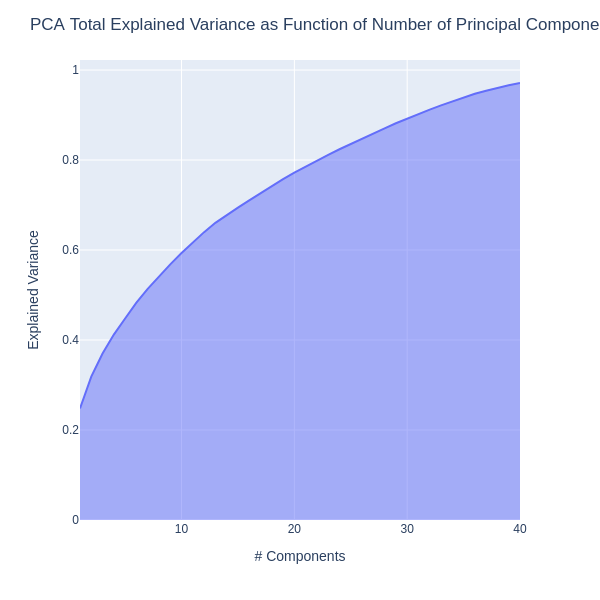
Deleted rows: 
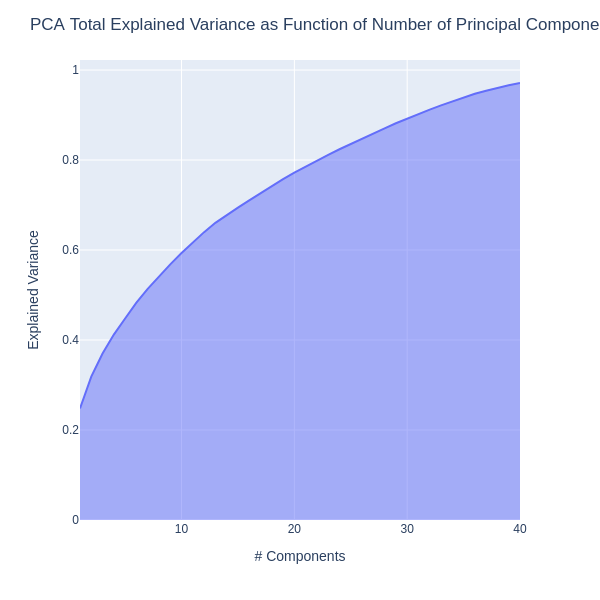

They show that with standardized data, 95% variance (desired amount) is only really achieved with about 35 principal components (which is about half that of the total number of variables). The top 10 components cover about 60% of the cumulative explained variance. However selecting 10 components does meet a point of diminishing returns on incremental explained variance.  

In [ ]:
# Only do this if we are saving our plots, else skip
if savePlots == True: 
    # Cumulative explained variance for analysis
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
    # Create and save the plot with explained variance
    fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
                  y=exp_var_cumul,
                  labels={"x": "# Components", "y": "Explained Variance"})
    fig.update_layout(title="PCA Total Explained Variance as Function of Number of Principal Components",
                      width = 600,
                      height = 600)
    fig.write_image("images/pca/" + deleteDescription + "/pca_explained_variance.png")
    if debug == True:
        print("PCA Total Explained Variance Plotting...success")
elif debug == True:
    print("Save Plots turned off...skipping plotting PCA total variance analysis")

## Hierarchical Clustering

### Visualization
Plots output from this subsection are located in images/hierarchicalClustering
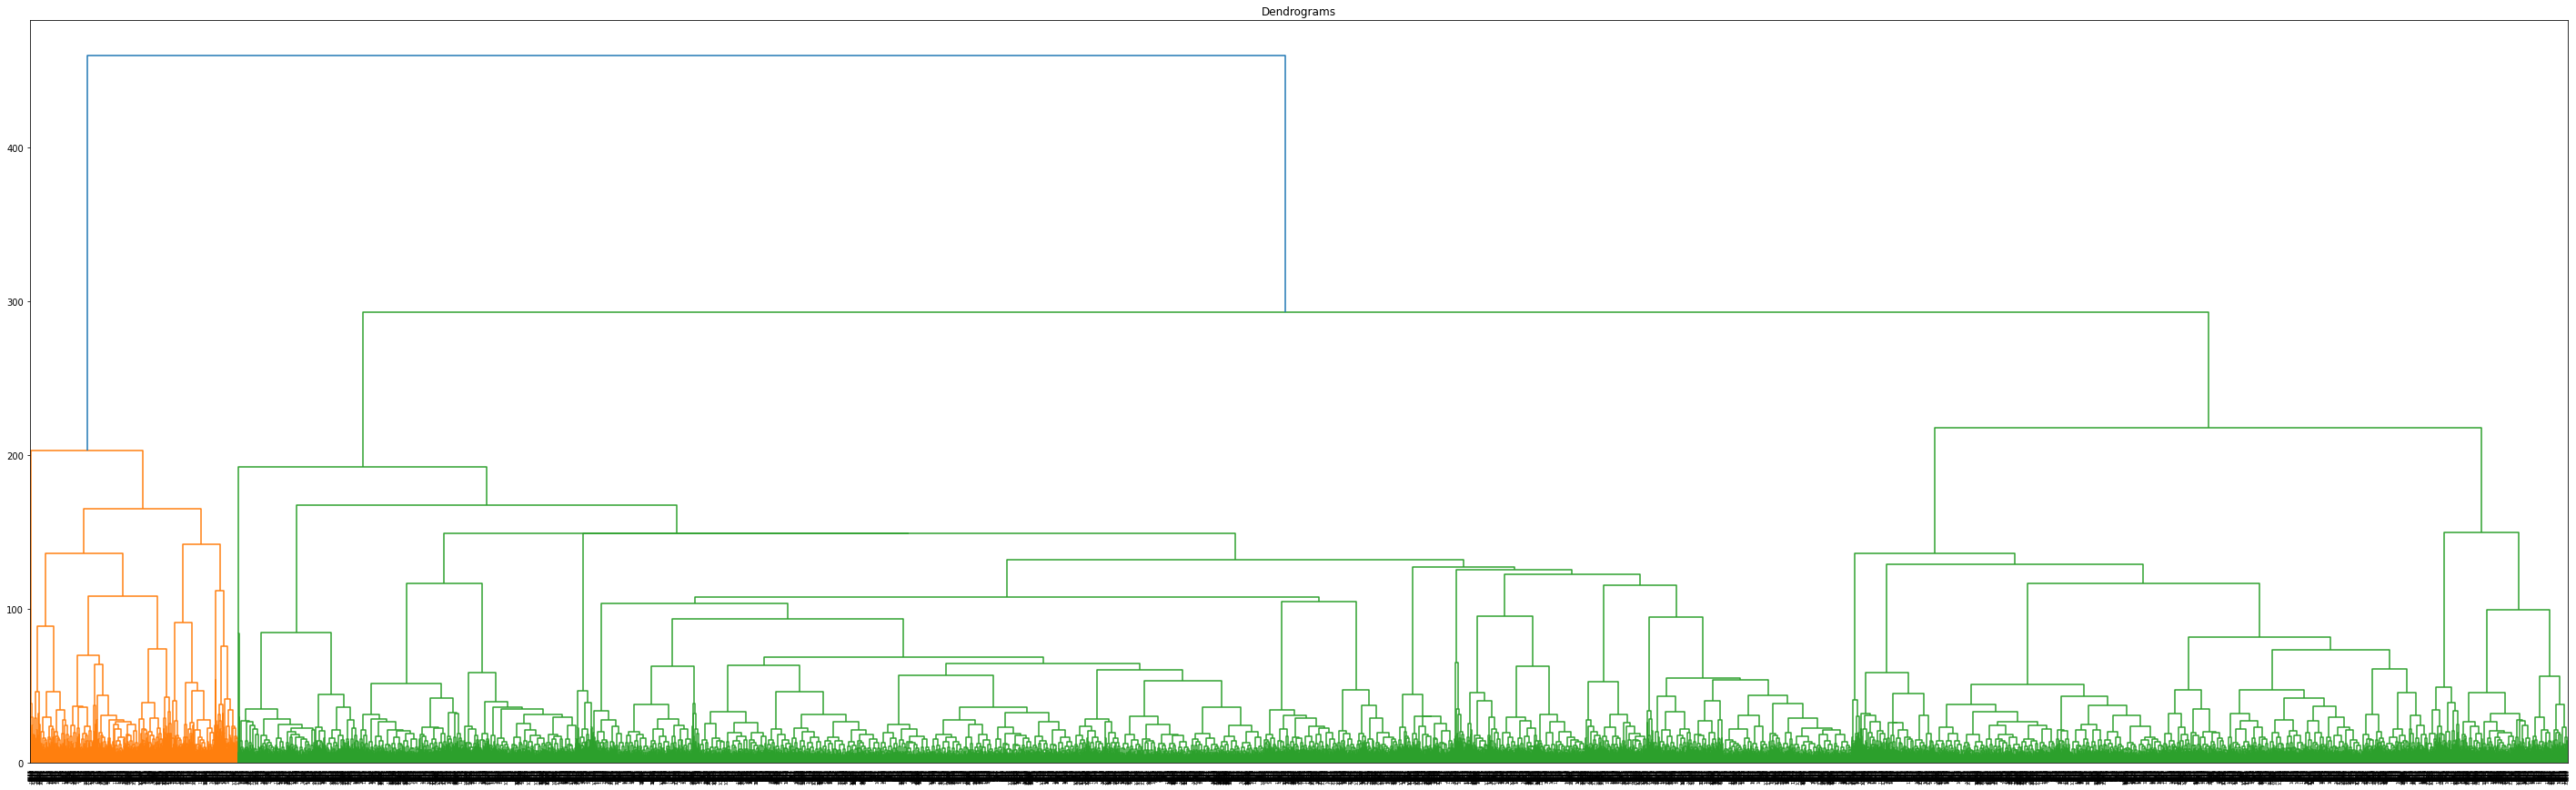

### Best Cut
While there is not necessarily a clear-cut way to determine where to cut a dendrogram, analysis of the scatter plots between variables tends to show much more clear segregation between 3 and 4 clusters: I would tend to cut at a threshold leading to 4 clusters. To get a cut of 4 clusters, a Euclidean distance threshold of 210 could achieve this cut.

### Distance Measure Used
#### Summary
Largely Euclidean distance was used for building the visualization and clustering models as the default, however “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, and “precomputed” parameters were each evaluated for building the models. 
#### Justification
Euclidean distance is fairly sufficient and uniform in constructing clusters that have been standardized.This data is looking exclusively at continuous variables, and not at correlation (1-r, like in genes), where the distance between two correlated vectors being 0 is of greater importance. Since there are still some slight outliers in the dataset, maximum distance would lead to possibly different sequences of the clustering that would be suboptimal. Even more so, manhattan distance would lead to less value in the hierarchical clustering algorithm given the high degree of dimensionality of the data set (or even simply taking our top 10 Principal Components).  

### Compare Branching Order to CART:
The dendrogram branching order splits off into couples at thresholds having differing numbers of point for each node until eventually all data points are accounted for. In random tree classifiers/regressors and forests, each tree is split off likewise into couples, however the number of branches varies significantly as branches are based on threshold values of variables moving down into a classification decision. This is opposed to a branch forming as the result of an iteration of the hierarchical classification algorithm grouping another point into a cluster

### References 
https://blog.quantinsti.com/hierarchical-clustering-python/
https://stats.stackexchange.com/questions/3685/where-to-cut-a-dendrogram
https://online.stat.psu.edu/stat555/node/85/#:~:text=For%20most%20common%20hierarchical%20clustering,correlation%20distance%20is%20often%20used.
https://wheatoncollege.edu/wp-content/uploads/2012/08/How-to-Read-a-Dendrogram-Web-Ready.pdf

### Initial Prompt
Use hierarchical clustering, visualize the tree and determine the best “cut”. What distance measure did you use? Why? Compare the branching order to the CART from module 2.

In [ ]:
# Import hierarchical clustering libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sc
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Variable to allow manipulating plot size
dendogramSize = (50, 15)
# Variable to allow manipulating the number of clusters we are thresholding heirarchical cluster
numClusters = 5

# Heirarchical clustering is computationally intensive so only do so if necessary
if True:
    # Plot dendrogram
    plt.figure(figsize=dendogramSize)  
    plt.title("Dendrograms")  

    # Create dendrogram
    dendrogram = sc.dendrogram(sc.linkage(df_num, 'ward'),
                              show_leaf_counts=True)
    # Save plot
    plt.savefig("images/hierarchicalClustering/hierarchicalClustering.png")

    # Output message
    if debug == True:
        print("Dendrogram Plotting...success")
elif debug == True:
    print("Save Plots turned off...skipping plotting dendrogram for hierarchical clustering")

# Perform Agglomerative Clustering for the given number of clusters
dataArr = df_num.iloc[:,:].values
cluster = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_num)

if savePlots == True:
    # Iterate through columns for given number of clusters
    for i in range(0, len(df_num.columns), 2):
        # Create appropriate file name and store it into clean directory
        path = "images/hierarchicalClustering/" + str(numClusters)
        if not os.path.exists(path):
            os.mkdir(path)
        fileName = path + "/" + df_num.columns[i] + '_' + df_num.columns[i+1]
        # Configure the plot given the number of clusters
        plt.figure(figsize = (10, 7))
        plt.scatter(dataArr[:,i], dataArr[:,i+1], c = cluster.labels_, cmap = 'rainbow')
        plt.title("Hierarchical Clustering: " + fileName)
        plt.xlabel(df_num.columns[i], fontsize=16)
        plt.ylabel(df_num.columns[i+1], fontsize=16)
        plt.savefig(fileName)
        if debug == True:
            print("hierarchical clustering plot created: ", fileName)
    if debug == True:
        print("Finished plotting hierarchical cluster scatter plots")
elif debug == True:
    print("Save Plots turned off...skipping plotting scatter plots of continuous variables with cluster labels")
    

## K-Means Clustering Visualization and Analysis
Here, necessary libraries for k-means are imported and the data-set is scaled to be normalized for Euclidean distance. Afterwards, if desired (i.e. "savePlots" flag is on), plots of functions for k-means metrics to the number of clusters are created and saved. 

The visualization portion of this following block can simply be skipped, and k-means will be ran on our optimal number of clusters, which is 3. 

The initial centroid points were ran both with random and with k-means++, which initializes the centroids. Most subsequent runs past analysis and visualization were ran with k-means++ because it is most likely to compute a competitive solution with the original k-means algorithm.

### Chosen K:
I found 4 to be the optimal value for both metrics (Dunn Index & Silhouette Coefficients).
   1) For SSE, even though the error remains high throughout, and the graph does not diminish as hyperbolically as desired to illustrate returns, there is still a slight elbow at 4 clusters for k-means++ initialization. Subsequent runs with Randomized initialization of centroids resulted in no elbow at 3, but a small elbow at 4 clusters as well.
   2) The silhouette coefficients show a must more significant diminish in returns for the number of clusters being created at 4 clusters for k-means++ initialization. Subsequent runs with randomized initialization of centroids resulted in a very sharp elbow at 3 clusters, rather than 4.
Given this challenge in selecting an elbow given slightly conflicting metrics for slightly conflicting parameters, I opted to select a k value of 4. My reasoning in this final selection was that it is best to avoid losing significance and increasing the training time. Additionally, perhaps there exist some outliers in the dataset which have distance values that would otherwise drag centroids, but would perhaps gain value in their own clusters.

### Chosen Distance Type:
#### Background: 
K-means algorithm most commonly supports: Euclidean distance measure, Manhattan distance measure, A squared euclidean distance measure, and Cosine distance measure. I started running the algorithm with Euclidean distance measure as it is the default and also most generally-intuitive measure.

### What does this tell you about the data:

### References: 
https://realpython.com/k-means-clustering-python/#:~:text=The%20k%2Dmeans%20clustering%20method,the%20oldest%20and%20most%20approachable.
https://www.simplilearn.com/tutorials/machine-learning-tutorial/k-means-clustering-algorithm#what_is_meant_by_the_kmeans_clustering_algorithm

### Initial Prompt
Cluster the same data using K-means.
Why did you choose that K and type of distance?
What does this tell you about the data



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For visualization of how many clusters to go with and saving runtime we threshold
maxClusters = 20
initializationType = "random"#"k-means++"

# If we are skipping the plotting & analytics, simply create our clustering with best found value
chosenOptimalClusters = 4

# K-means has difficulty computing distance with different scaling - this normalizes
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_num)
        
# Performs 10 runs of K-means algorithm with 3 clusters and maximum of 300 iterations.
kmeansArgs = {
    "init" : initializationType,   # Both have been tried - optimal to intelligently initialize centroids
    "n_init" : 10,                 # Performs 10 runs
    "max_iter" : 300,              # At most 300 iterations - usually doesn't go through too many
    "random_state" : 42
}

# Compute and plot k-means cluster analysis
if savePlots == True:
    # K-means metric lists
    # Sum of Squares error for Euclidean distance
    sse = []
    # How well data point fits inside its own cluster and how far it is from other clusters
    silhouetteCoefficients = []
    # Run k-means parameters with various numbers of clusters and obtain metrics
    for k in range(1, maxClusters+1):
        kmeans = KMeans(n_clusters=k, **kmeansArgs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
        # Silhouette Score needs at least two clusters to run
        if k > 1:
            score = silhouette_score(scaled_features, kmeans.labels_)
            silhouetteCoefficients.append(score)
    # Create a nice folder to store the plots, if necessary
    path = "images/k_means/" + initializationType
    if not os.path.exists(path):
        os.mkdir(path)
    # Plot SSE as function of number of clusters
    plt.plot(range(0, len(sse)), sse)
    plt.xticks(range(0, len(sse)+1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.savefig(path + "/sse_to_clusters.png")
    plt.clf()
    # Plot silhouette coefficients as function of number of clusters
    plt.plot(range(0, len(silhouetteCoefficients)), silhouetteCoefficients)
    plt.xticks(range(0, len(silhouetteCoefficients)+1))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficients")
    plt.savefig(path + "/silhouette_cofefficients_to_clusters.png")
    plt.clf()
    # Debugging output
    if debug == True:
        print("K-means cluster plots...success")
elif debug == True:
        print("Save plots off: skipping K-means cluster plots")

# After visualization we save our k-means data structure with optimal number of clusters
kmeans = KMeans(n_clusters=chosenOptimalClusters, **kmeansArgs)
#kmeans.fit(scaled_features)
y_predict= kmeans.fit_predict(scaled_features) 

if savePlots == True:
    # Iterate through columns for given number of clusters
    for i in range(0, len(df_num.columns), 2):
        # Create appropriate file name and store it into clean directory
        path = "images/k_means/" + str(chosenOptimalClusters)
        if not os.path.exists(path):
            os.mkdir(path)
        fileName = path + "/" + df_num.columns[i] + '_' + df_num.columns[i+1]
        # Configure the plot given the number of clusters
        plt.figure(figsize = (10, 7))
        plt.scatter(scaled_features[:,i], scaled_features[:,i+1], c = y_predict, cmap = 'rainbow')
        plt.title("K-Means Clustering: " + fileName)
        plt.xlabel(df_num.columns[i], fontsize=16)
        plt.ylabel(df_num.columns[i+1], fontsize=16)
        plt.savefig(fileName)
        if debug == True:
            print("K-means clustering plot created: ", fileName)
    if debug == True:
        print("Finished plotting K-means cluster scatter plots")
elif debug == True:
    print("Save Plots turned off...skipping plotting scatter plots of continuous variables with k-means cluster labels")


if debug == True:
    print("K-means initialization and visualization...success")

Cluster the same data using K-means.
Why did you choose that K and type of distance?
What does this tell you about the data?
